# **Exercise #1**

The  graph graph02072020.gmlcontains  a  set  of  potential locations that  a telecom company can connect witha network rooted in node 1.

Each location(node) u has  associated  a revenue[revenueattribute  in  the graph], a number of customers [customer attribute in the graph] and each edge uv has a connection cost[cost attribute in the graph].

- 1.Design a network that maximizes the company profit.
- 2.The company will receive an incentive of 1450 Euro if it connects at least 88% of the customers. Is it convenient to achieve this coverage target?
- 3.Design a network that maximizes the company profit with the constraint that the maximum number of hops from the root node cannot exceed 3.

For each configuration report the number of enumerated nodes and the value of the linear relaxation at the root node of the enumeration tree.

In [1]:
import networkx as nx
import gurobipy as gb
import os
import matplotlib.pyplot as plt

In [2]:
# Drawing functions

def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    figsize = 30,60
    scale = 40

## Prize Collecting Steiner Tree (PCST)

### Problem definition

>**Given**
> * A symmetric graph $G=(V,E)$ and a cost $c_e > 0$ for each edge in $E$;
> * A root node $\{0\}$;
> * A revenue $p_j > 0$ for each node $j \in V \setminus \{0\}$;

>
>**Find**
>A subtree $T$ rooted in $\{0\}$ that **maximizes** the sum of the revenues of 
>the nodes in $T$ **minus** the sum of the costs of the edges in $T$

### Directed formulation

Consider the bidirected graph $B=(V,A)$ that is obtained from $G$ by replacing each edge $e = \{i, j\}$ in $E$ with two directed arcs $(i, j)$ and
$(j, i)$ (with corresponding weights $c_{ij} = c_{ji} = c_e )$ and a cost $c_e > 0$ for each edge in $E$

> **PCST** is equivalent to find an optimal **arborescence** in $B$ rooted in $\{0\}$


#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

#### Directed cut formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
\sum_{(i,j)\in \delta^+(S) x_{ij}} x_{ij}& \ge y_k \;\; \forall S \subset V, 0 \in S, k \in V\setminus S\\
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$

### Formulation with *positional* variables (MTZ formulation)

#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$ 
u_j = \{\text{number of arcs in the dipath (if any) induced by $x$ from \{0\} to $j$}\}
$$

#### MTZ formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
(n+1)x_{ij} + u_i - u_j &\le n \;\; \forall (i,j) \in A \\
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


In [3]:
# Read the graph in the graphML format

args.filename = 'graph02072020.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml(args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

root = 1 # fix the root node

# rendiamo il grafo G diretto
D = G.to_directed()

G has 30 nodes and 435 edges


## **Ex1.1 ->** Design a network that maximizes the company profit

In [4]:
pcst = gb.Model()
pcst.ModelSense = gb.GRB.MAXIMIZE

# Variables definition

x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')

Academic license - for non-commercial use only - expires 2021-07-16
Using license file /home/leonardo/gurobi.lic


In [5]:
# Constraints 

# Root is in the solution
pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

# Each node has exactly one incoming arc

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

# Precedence constraints (MTZ constraints)

pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] + u[i] - u[j] <= G.number_of_nodes() for i,j in D.edges()), name = 'MTZ')

# Connectivity constraints

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst.update() 

pcst.write('pcst.lp')


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1741 rows, 930 columns and 5163 nonzeros
Model fingerprint: 0xe2852160
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 176.0000000
Presolve removed 59 rows and 31 columns
Presolve time: 0.02s
Presolved: 1682 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 5.608785e+03, 61 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5608.78495    0   27  176.00000 5608.78495  3087%     -    0s
H    0     0                     454.0000000 

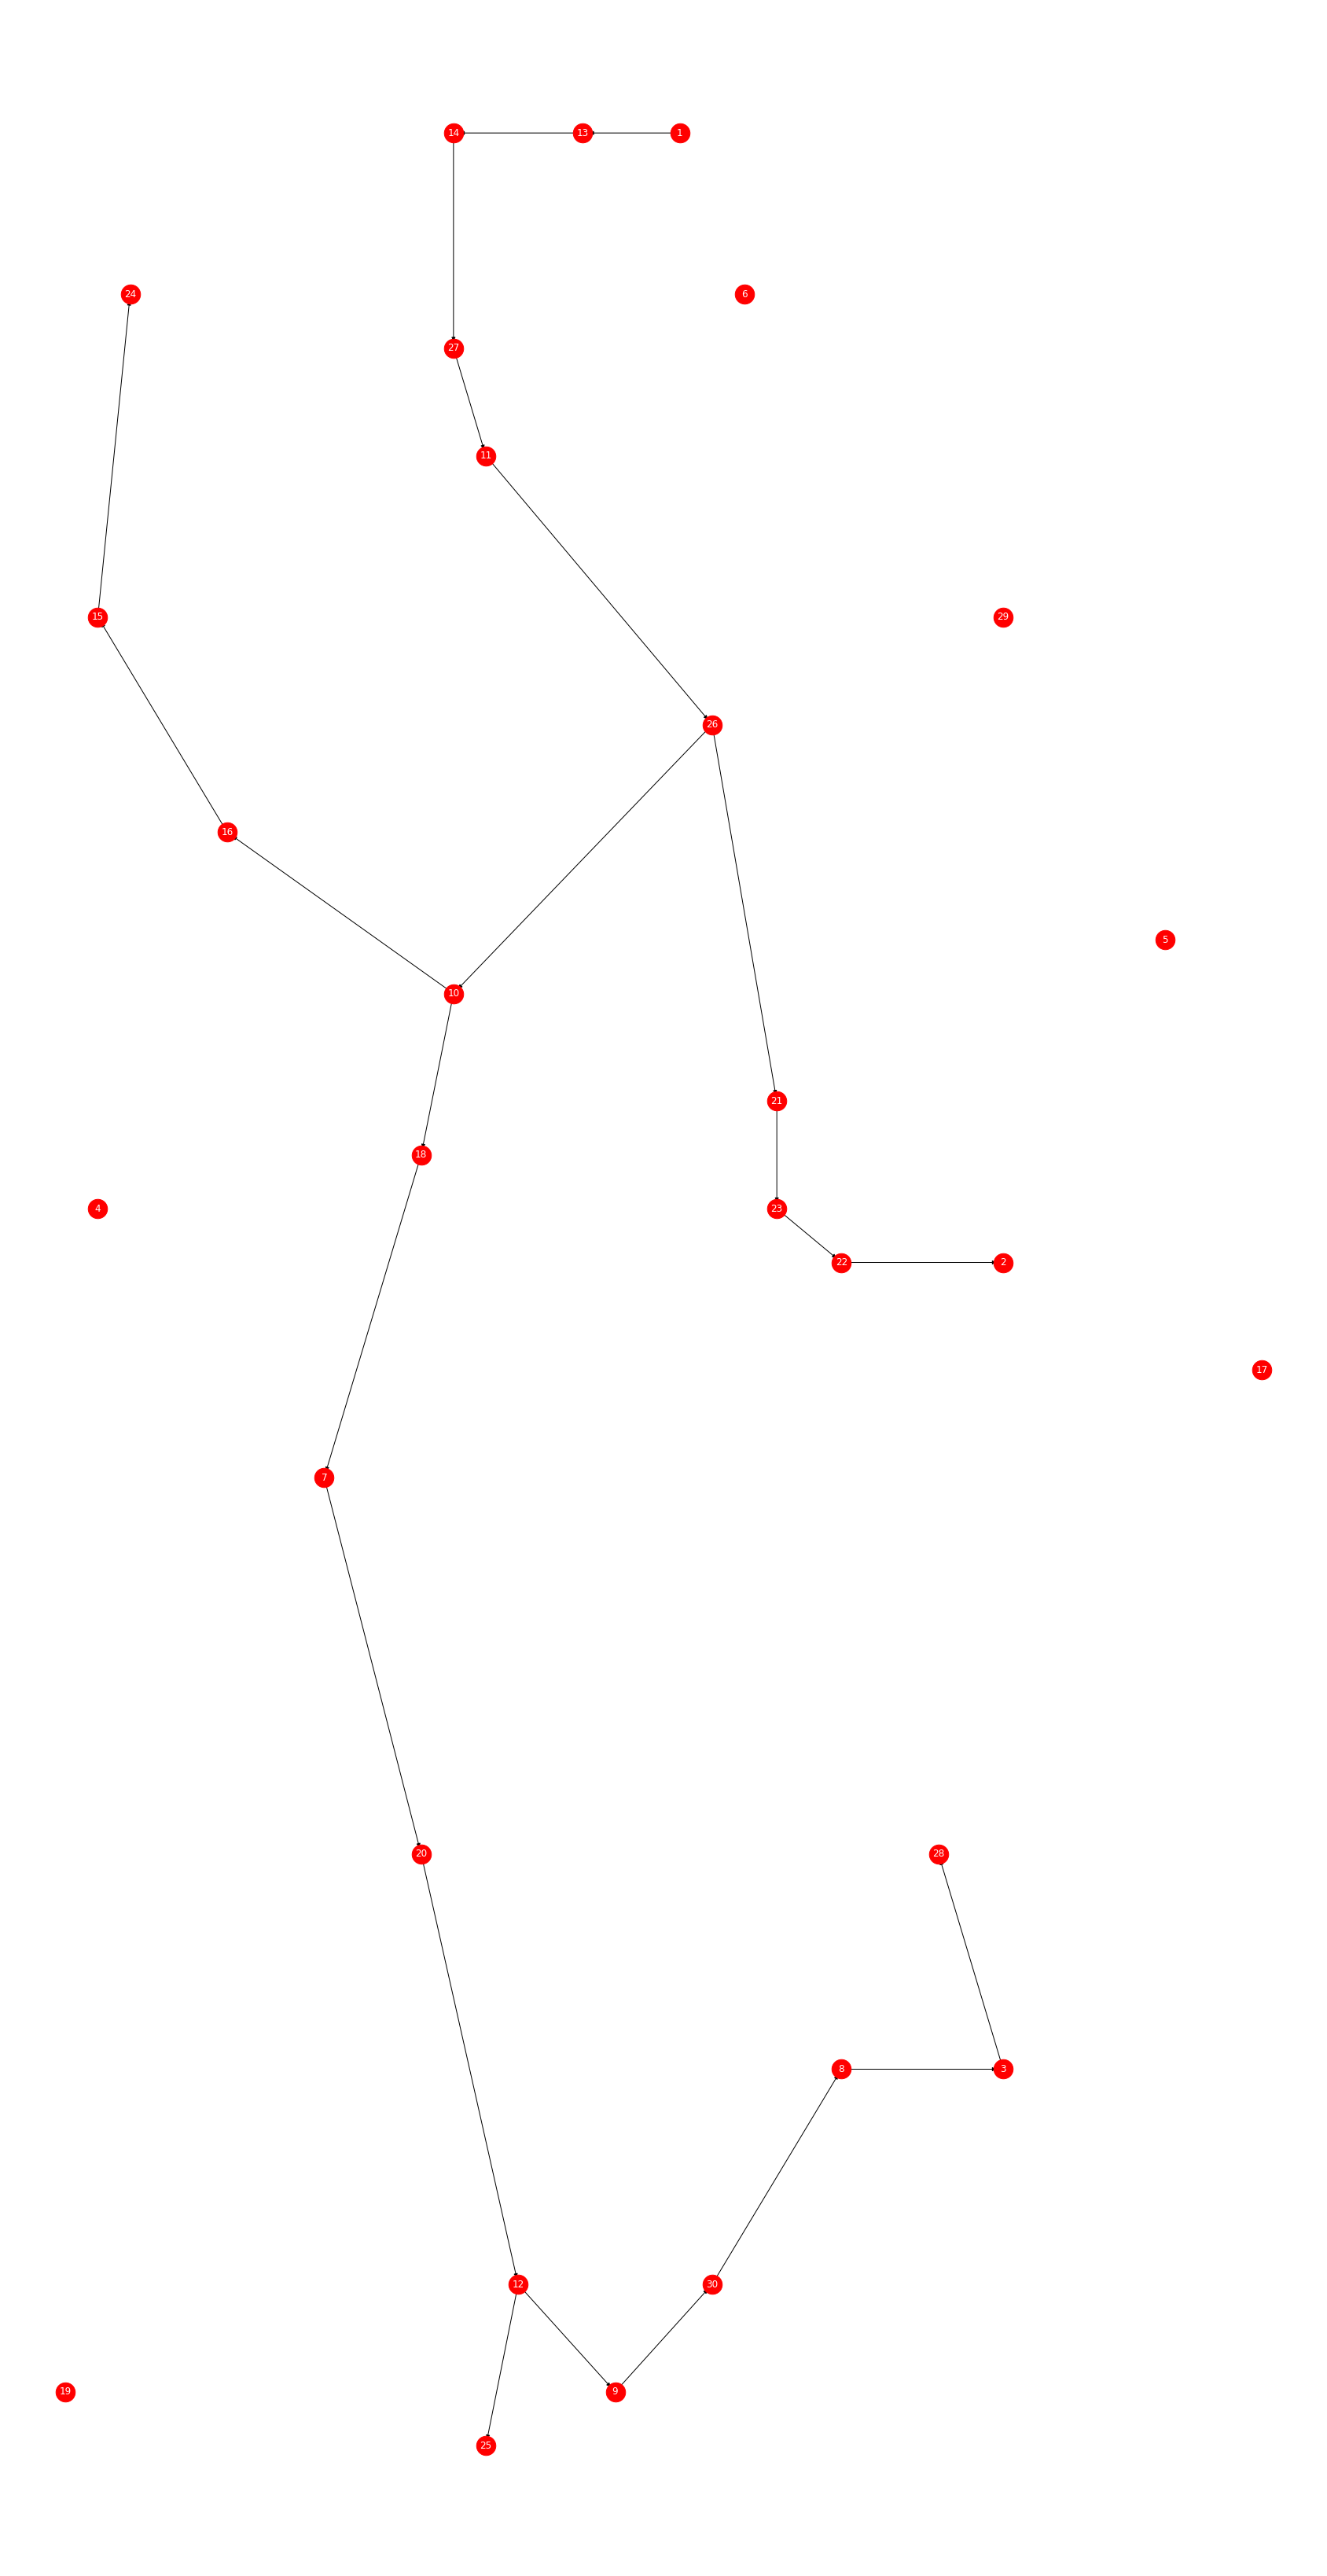

In [6]:
pcst.optimize()

totalcost = 0

for i,j in D.edges():
        if x[i,j].x > 0.1:
            totalcost += D[i][j]['cost']
            
print("\n------------------------------------------------------------------------------\n")
print ("Total cost", totalcost)
print("\n------------------------------------------------------------------------------\n")

# Draw the solution 
DrawSol(D,x)

## **Ex1.2->** The company will receive an incentive of 1450 Euro if it connects at least 88% of the customers. Is it convenient to achieve this coverage target?

In [7]:
incentive = 1450

customers = {i:G.nodes[i]["customer"] for i in G.nodes()}
n_customers = sum([G.nodes[i]["customer"] for i in G.nodes()])
min_customers = 0.88*n_customers

pcst.addConstr(y.prod(customers) >= min_customers, name = 'Incentivo')
pcst.update() 
pcst.write('pcst.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1742 rows, 930 columns and 5193 nonzeros
Model fingerprint: 0x54bf23ab
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 1e+05]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint Incentivo by 25046.560000000

Presolve removed 87 rows and 32 columns
Presolve time: 0.03s
Presolved: 1655 rows, 898 columns, 5007 nonzeros
Variable types: 29 continuous, 869 integer (869 binary)
Found heuristic solution: objective -20823.00000

Root relaxation: objective 4.235212e+03, 70 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent

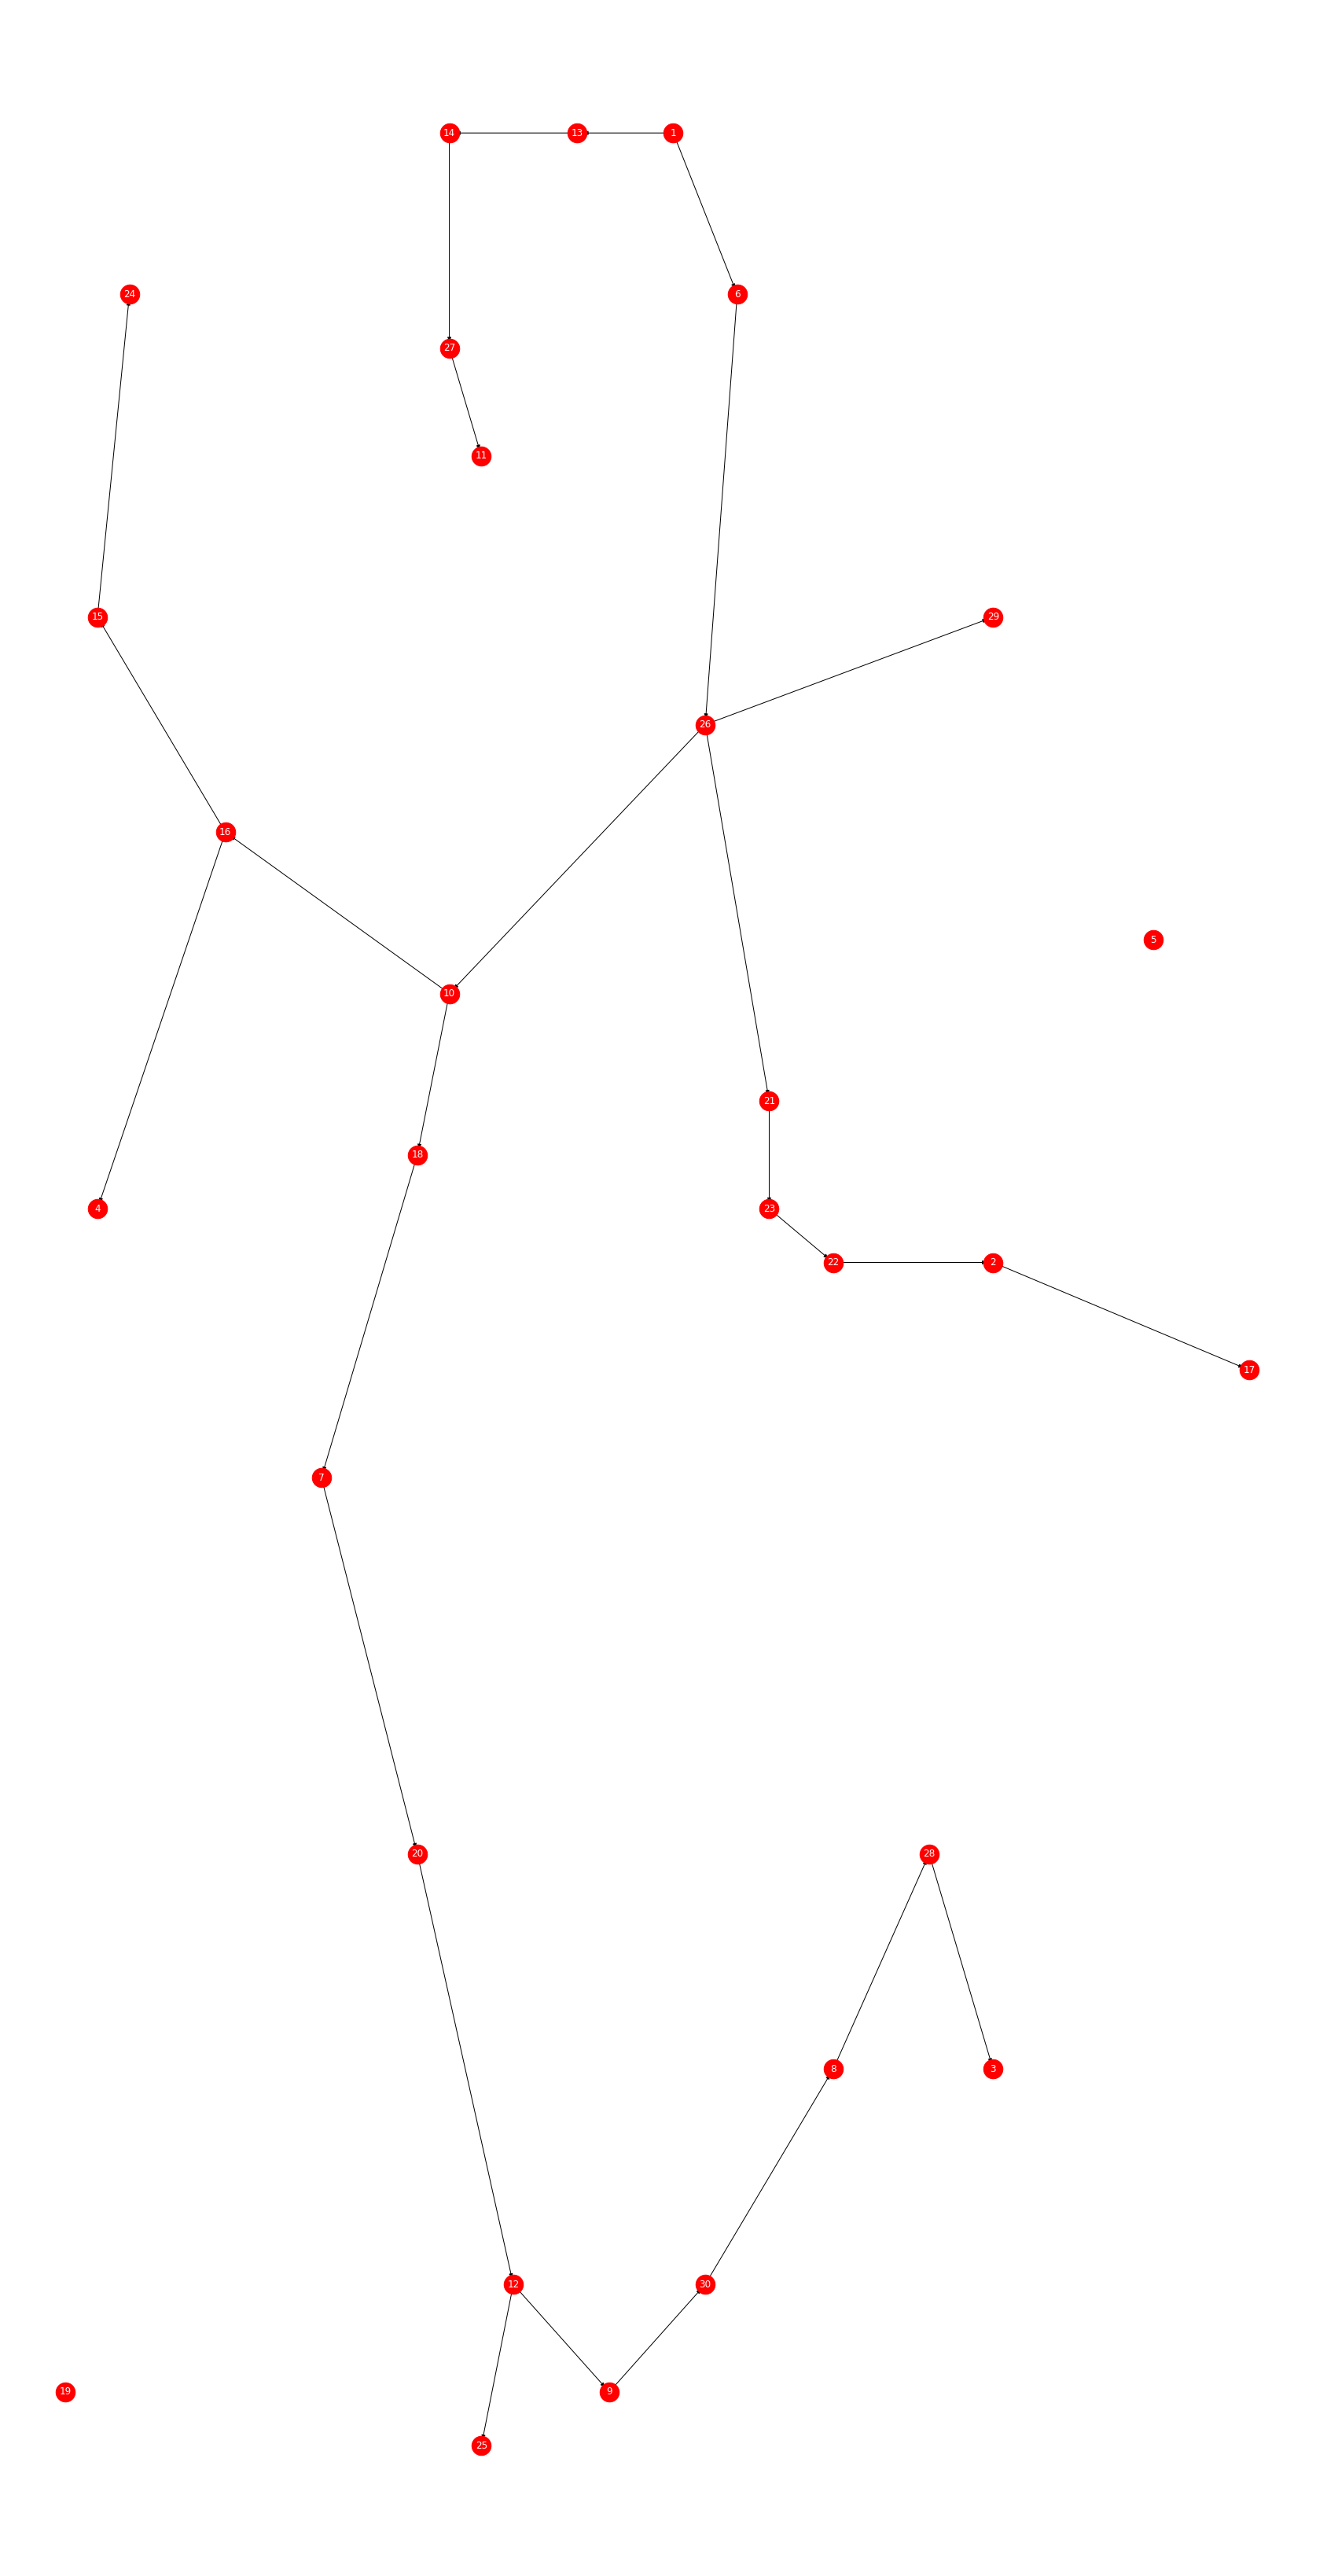

In [8]:
pcst.optimize()

totalcost = -incentive

for i,j in D.edges():
        if x[i,j].x > 0.1:
            totalcost += D[i][j]['cost']

print("\n------------------------------------------------------------------------------\n")
print ("Total cost", totalcost)
print("\n------------------------------------------------------------------------------\n")

# Draw the solution 
DrawSol(D,x)

## **Ex1.3 ->** Design a network that maximizes the company profit with the constraint that the maximum number of hops from the root node cannot exceed 3.

#### MTZ formulation with max number of hops
we define h as the maximum number oh hops, then we change the precedence constraint and the apperbound of $u_j$:

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
(h+1)x_{ij} + u_i - u_j &\le h \;\; \forall (i,j) \in A \\
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le h \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


In [9]:
# Read the graph in the graphML format

args.filename = 'graph02072020.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml(args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

root = 1 # fix the root node

# rendiamo il grafo G diretto
D = G.to_directed()

G has 30 nodes and 435 edges


In [10]:
pcst = gb.Model()
pcst.ModelSense = gb.GRB.MAXIMIZE

# Variables definition

hops = 3

x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = hops, name = 'u')

In [11]:
# Constraints definition

# Root is in the solution
pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

# Each node has exactly one incoming arc

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

# Precedence constraints (MTZ constraints)

pcst.addConstrs(((hops +  1) * x[i,j] + u[i] - u[j] <= hops for i,j in D.edges()), name = 'MTZ')

# Connectivity constraints

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst.update() 
pcst.write('pcst.lp')

In [12]:
pcst.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1741 rows, 930 columns and 5163 nonzeros
Model fingerprint: 0x60d87cc2
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 176.0000000
Presolve removed 59 rows and 31 columns
Presolve time: 0.02s
Presolved: 1682 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 5.290083e+03, 61 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5290.08333    0   27  176.00000 5290.08333  2906%     -    0s
H    0     0                     454.0000000 


------------------------------------------------------------------------------

Total cost 1088

------------------------------------------------------------------------------



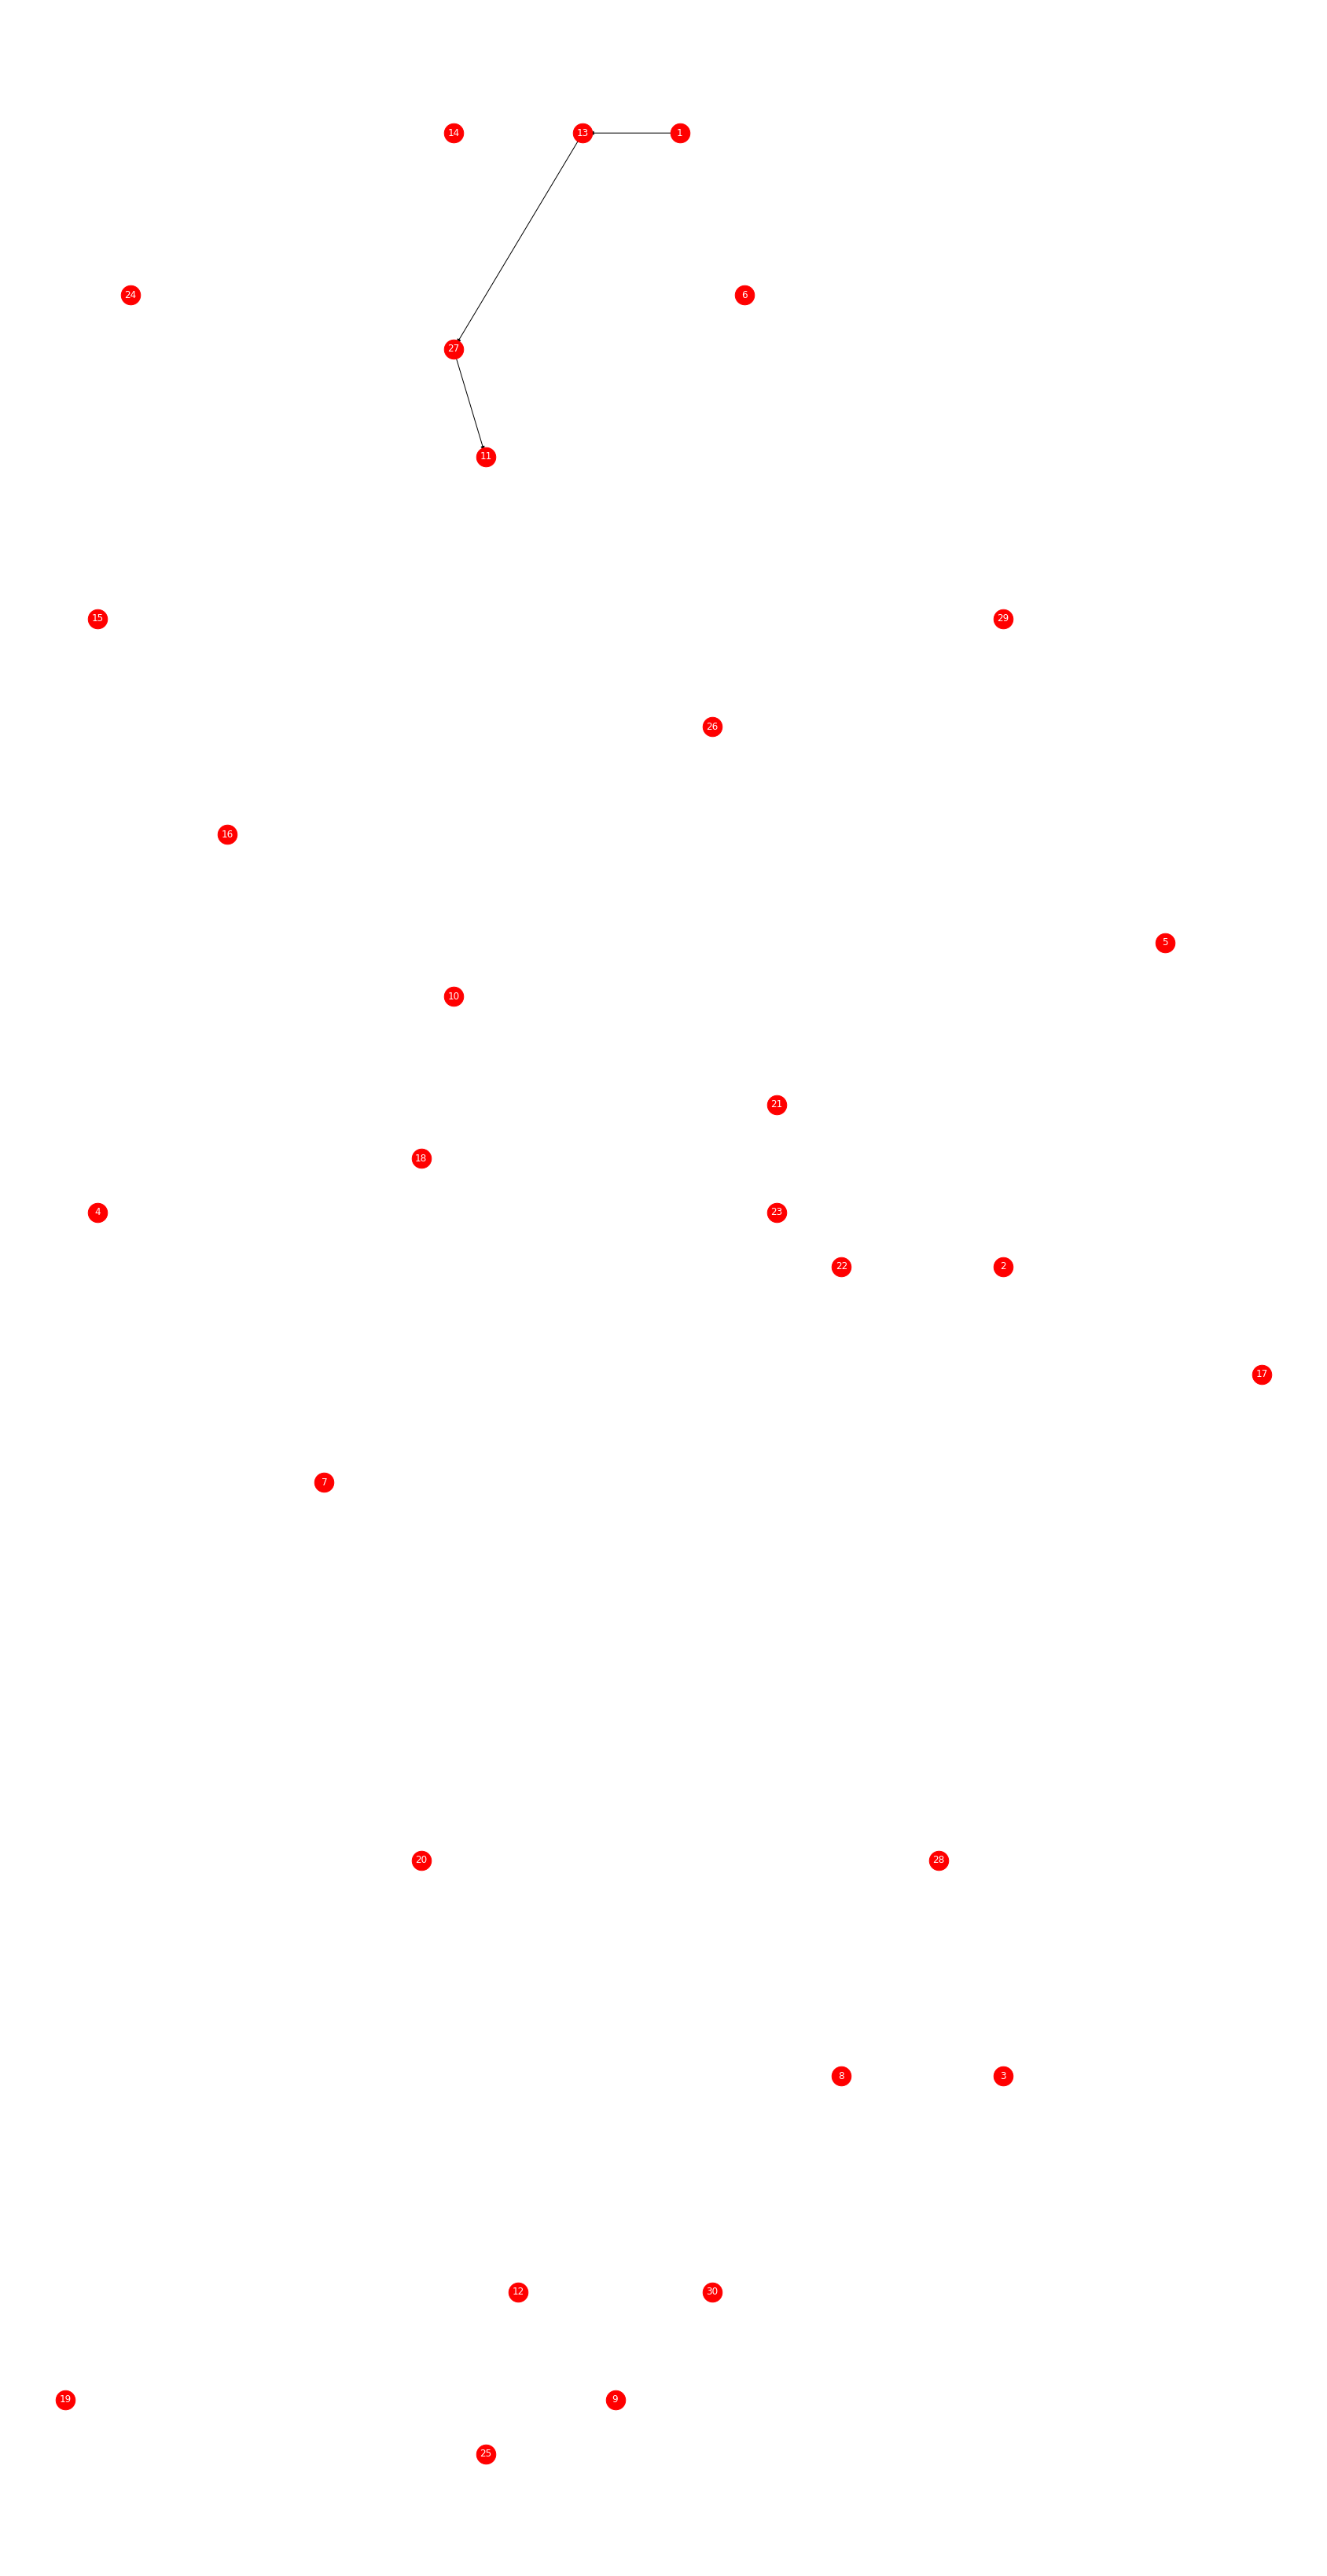

In [13]:
totalcost = 0

for i,j in D.edges():
        if x[i,j].x > 0.1:
            totalcost += D[i][j]['cost']

print("\n------------------------------------------------------------------------------\n")
print ("Total cost", totalcost)
print("\n------------------------------------------------------------------------------\n")

# Draw the solution 
DrawSol(D,x)